In [1]:
import pandas as pd
import numpy as np
import pylab as pl
%pylab inline
import geopandas as gpd
import scipy.stats 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import mplleaflet

Populating the interactive namespace from numpy and matplotlib


In [474]:
#Importing 311 data
#Source: https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9
data_311 = pd.read_csv('311_Service_Requests_from_2010_to_Present.csv')
data_311 = data_311[['Unique Key', 'Created Date', 'Complaint Type', 'Descriptor', 
                     'Incident Zip', 'Borough']]
data_311 = data_311.replace('Mouse Sighting', 'Rat Sighting')
data_311 = data_311.rename(columns = {'Incident Zip':'ZIP'})
data_311['Year'] = pd.DatetimeIndex(data_311['Created Date']).year
data_311r = data_311[data_311['Year']>=2014]                                    
data_311.head()

,Unique Key,Created Date,Complaint Type,Descriptor,ZIP,Borough,Year
0,32154713,12/08/2015 12:39:42 AM,Rodent,Rat Sighting,11211,BROOKLYN,2015
1,32153645,12/08/2015 12:36:56 AM,Rodent,Rat Sighting,10001,MANHATTAN,2015
2,32151473,12/07/2015 11:38:19 PM,Rodent,Rat Sighting,10011,MANHATTAN,2015
3,32148435,12/07/2015 11:16:31 PM,Rodent,Rat Sighting,11237,BROOKLYN,2015
4,32149313,12/07/2015 11:15:35 PM,Rodent,Rat Sighting,11210,BROOKLYN,2015


In [403]:
#Importing 2014 Census data
#Source: http://factfinder.census.gov/faces/nav/jsf/pages/index.xhtml
data_census14 = pd.read_csv('ACS_14_5YR_B19013/ACS_14_5YR_B19013.csv')
data_census14 = data_census14.rename(columns = {'HD01_VD01':'Median Household Income 2014'})
data_census14.head()

,GEO.id,GEO.id2,GEO.display-label,Median Household Income 2014,HD02_VD01
0,Id,Id2,Geography,Estimate; Median household income in the past ...,Margin of Error; Median household income in th...
1,1400000US36001000100,36001000100,"Census Tract 1, Albany County, New York",30750,14345
2,1400000US36001000200,36001000200,"Census Tract 2, Albany County, New York",21283,6579
3,1400000US36001000300,36001000300,"Census Tract 3, Albany County, New York",31591,13372
4,1400000US36001000401,36001000401,"Census Tract 4.01, Albany County, New York",71343,4420


In [405]:
#Importing 2009 Census data
#Source: http://factfinder.census.gov/faces/nav/jsf/pages/index.xhtml
data_census09 = pd.read_csv('ACS_09_5YR_B19013/ACS_09_5YR_B19013.csv')
data_census09 = data_census09.rename(columns = {'HD01_VD01':'Median Household Income 2009'})
data_census09['GEO.id2'] = data_zcta['GEO.id2'].apply(str)
data_census09.head()

,GEO.id,GEO.id2,GEO.display-label,Median Household Income 2009,HD02_VD01
0,1400000US36001000100,72001956300,"Census Tract 1, Albany County, New York",37619,11511
1,1400000US36001000200,72001956400,"Census Tract 2, Albany County, New York",26552,1700
2,1400000US36001000300,72001956500,"Census Tract 3, Albany County, New York",38750,7868
3,1400000US36001000401,72001956600,"Census Tract 4.01, Albany County, New York",62039,25279
4,1400000US36001000403,72001956700,"Census Tract 4.03, Albany County, New York",53644,9829


In [4]:
#Loading zip codes data
#http://www.udsmapper.org/zcta-crosswalk.cfm
data_zipcodes = pd.read_excel('zip_to_zcta_2015.xlsx')
data_zipcodes = data_zipcodes[['ZIP','ZCTA']]
data_zipcodes.head()

,ZIP,ZCTA
0,96916,96916
1,96917,96917
2,96928,96928
3,96915,96915
4,96923,96913


In [395]:
#Importing ZCTA code file
#https://www.census.gov/geo/maps-data/data/zcta_rel_download.html
data_zcta = pd.read_csv('zcta_tract_rel_10.txt')
data_zcta = data_zcta.rename(columns = {'GEOID':'GEO.id2'})
data_zcta['GEO.id2'] = data_zcta['GEO.id2'].apply(str)
data_zcta.head()

,ZCTA5,STATE,COUNTY,TRACT,GEO.id2,POPPT,HUPT,AREAPT,AREALANDPT,ZPOP,...,TRAREA,TRAREALAND,ZPOPPCT,ZHUPCT,ZAREAPCT,ZAREALANDPCT,TRPOPPCT,TRHUPCT,TRAREAPCT,TRAREALANDPCT
0,601,72,1,956300,72001956300,4271,1706,44663250,44572589,18570,...,44924558,44833897,23.00,22.03,26.67,26.74,98.5,98.33,99.42,99.42
1,601,72,1,956400,72001956400,2384,1037,32830481,32492074,18570,...,37782601,37191697,12.84,13.39,19.61,19.50,79.6,80.14,86.89,87.36
2,601,72,1,956500,72001956500,3126,1240,44969548,44809680,18570,...,44969548,44809680,16.83,16.01,26.85,26.89,100.0,100.00,100.00,100.00
3,601,72,1,956600,72001956600,2329,972,1981101,1981101,18570,...,1981101,1981101,12.54,12.55,1.18,1.19,100.0,100.00,100.00,100.00
4,601,72,1,956700,72001956700,2053,948,1380041,1380041,18570,...,1380041,1380041,11.06,12.24,0.82,0.83,100.0,100.00,100.00,100.00


In [418]:
#Including ZCTA codes in Census data
census_zcta = pd.merge(data_census14, data_zcta, on=['GEO.id2']) 
census_zcta = pd.merge(data_census09, census_zcta, on=['GEO.id']) 
census_zcta = census_zcta[['ZCTA5', 'Median Household Income 2014','Median Household Income 2009']]
census_zcta = census_zcta.rename(columns = {'ZCTA5':'ZCTA'})
census_zcta = census_zcta[(~pd.isnull(census_zcta['Median Household Income 2014'])) & \
                          (~pd.isnull(census_zcta['Median Household Income 2009']))]
census_zcta['Median Household Income 2014'] = census_zcta['Median Household Income 2014'].apply(int)
census_zcta['Median Household Income 2009'] = census_zcta['Median Household Income 2009'].apply(int)
census_zcta.head()

,ZCTA,Median Household Income 2014,Median Household Income 2009
0,12204,30750,37619
1,12207,30750,37619
2,12204,21283,26552
3,12207,21283,26552
4,12210,21283,26552


In [420]:
#Including ZIP code in Census in Census data
census_zip = pd.merge(census_zcta, data_zipcodes, on=['ZCTA'])
census_zip = census_zip[['ZIP', 'Median Household Income 2009', 'Median Household Income 2014']]
census_zip = census_zip.groupby(['ZIP']).mean()
census_zip['ZIP'] = census_zip.index
census_zip.index = range(len(census_zip['ZIP']))
census_zip.head()

,Median Household Income 2009,Median Household Income 2014,ZIP
0,92221.600000,89346.200000,501
1,92221.600000,89346.200000,544
2,67425.000000,70313.000000,6390
3,89634.363636,110507.090909,10001
4,36513.533333,39705.866667,10002


In [9]:
#Importing population data
pop_zip = pd.read_csv('Census_2010.csv')
pop_zip = pop_zip[['Zipcode', 'Total']]
pop_zip = pop_zip.rename(columns = {'Zipcode':'ZIP'})
pop_zip = pop_zip.rename(columns = {'Total':'Population'})
pop_zip = pop_zip.groupby(['ZIP']).sum()
pop_zip['ZIP'] = pop_zip.index
pop_zip.index = range(0,len(pop_zip))
pop_zip['ZIP'] = pop_zip['ZIP'].apply(int)
pop_zip.head()

,Population,ZIP
0,21102,10001
1,81410,10002
2,56024,10003
3,3089,10004
4,7135,10005


In [324]:
#Loading MapPLUTO data
bk_mappluto = gpd.GeoDataFrame.from_file("Brooklyn/BKMapPLUTO.shp")
mn_mappluto = gpd.GeoDataFrame.from_file("Manhattan/MNMapPLUTO.shp")

NameError: name 'gp' is not defined

In [329]:
data_mappluto =  gpd.GeoDataFrame(pd.concat([mn_mappluto, bk_mappluto], ignore_index=True))
data_mappluto = data_mappluto.rename(columns = {'ZipCode':'ZIP'})
print data_mappluto.columns

Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

In [337]:
year_zip = data_mappluto[['ZIP', 'YearBuilt']]
year_zip = year_zip[year_zip['YearBuilt']>0]
year_zip = year_zip[year_zip['ZIP']>0]
year_zip = year_zip.groupby(['ZIP']).mean()
year_zip['ZIP'] = year_zip.index
year_zip.index = range(0,len(year_zip))
year_zip['YearBuilt'] = np.round(year_zip['YearBuilt'])
year_zip.head()

,YearBuilt,ZIP
0,1926,10001
1,1920,10002
2,1915,10003
3,1929,10004
4,1934,10005


In [429]:
#Calculating complaints by ZIP
complaints_zip = pd.DataFrame(data_311['Unique Key'].groupby(data_311['ZIP']).count())
complaints_zip['ZIP'] = complaints_zip.index
complaints_zip.index = range(0,len(complaints_zip))
complaints_zip = complaints_zip.rename(columns = {'Unique Key':'Total Complaints'})

complaints_zipr = pd.DataFrame(data_311r['Unique Key'].groupby(data_311['ZIP']).count())
complaints_zipr['ZIP'] = complaints_zipr.index
complaints_zipr.index = range(0,len(complaints_zipr))
complaints_zipr = complaints_zipr.rename(columns = {'Unique Key':'Complaints 2014-15'})

#Sighting vs. conditions correlation
df_sight = data_311[data_311['Descriptor'] == 'Rat Sighting']
df_sight = pd.DataFrame(df_sight['Unique Key'].groupby(df_sight['ZIP']).count())
df_sight['ZIP'] = df_sight.index
df_sight.index = range(0,len(df_sight))
df_sight = df_sight.rename(columns = {'Unique Key':'Rat Sighting'})
complaints_zip = pd.merge(complaints_zip, df_sight, on=['ZIP'])

df_cond = data_311[data_311['Descriptor'] == 'Condition Attracting Rodents']
df_cond = pd.DataFrame(df_cond['Unique Key'].groupby(df_cond['ZIP']).count())
df_cond['ZIP'] = df_cond.index
df_cond.index = range(0,len(df_cond))
df_cond = df_cond.rename(columns = {'Unique Key':'Condition Attracting Rodents'})
complaints_zip = pd.merge(complaints_zip, df_cond, on=['ZIP'])

complaints_zip.head()

,Total Complaints,ZIP,Rat Sighting,Condition Attracting Rodents
0,446,10001,336,78
1,1533,10002,1047,283
2,886,10003,663,169
3,50,10004,36,8
4,26,10005,12,11


In [339]:
#Loading NYC map as Geopandas 
#http://data.nycprepared.org/dataset/nyc-zip-code-tabulation-areas/resource/0c0e14e9-78e1-404e-97b0-c2fabceb3981
nyc_map = gpd.read_file('nyc-zip-code-tabulation-areas-polygons.geojson')
nyc_map = nyc_map.rename(columns = {'postalCode':'ZIP'})
nyc_map['ZIP'] = nyc_map['ZIP'].apply(int)

In [278]:
#Creating area df
area_zip = nyc_map[['Shape_Area', 'ZIP']]
area_zip['Shape_Area'] = area_zip['Shape_Area']/1000000 
area_zip.head()

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,Shape_Area,ZIP
0,20.163284,11372
1,22.606527,11004
2,6.269333,11040
3,49.418364,11426
4,69.385866,11365


In [432]:
#Merging all ZIP data
df = pd.merge(census_zip, area_zip, on=['ZIP'])
df = pd.merge(df, pop_zip, on=['ZIP'])
df = pd.merge(df, complaints_zip, on=['ZIP'])
df = pd.merge(df, complaints_zipr, on=['ZIP'])
df = pd.merge(df, year_zip, on=['ZIP'])

#Adding other columns
df['Complaints Per 1,000 People'] = df['Total Complaints']/df['Population']*1000
df['Complaints 2014-15 Per 1,000 People'] = df['Complaints 2014-15']/df['Population']*1000
df['Complaints Per Km2'] = df['Total Complaints']/df['Shape_Area']
df['Population Density'] = df['Population']/df['Shape_Area']
df['Income Growth'] = (df['Median Household Income 2014']/df['Median Household Income 2009']-1)*100
df = df[(np.isfinite(df['Median Household Income 2009'])) & (np.isfinite(df['Median Household Income 2014'])) & (np.isfinite(df['Complaints Per 1,000 People'])) & 
        (df['Complaints Per 1,000 People']<150) & (df['Population']>5000)]
df.head()

,Median Household Income 2009,Median Household Income 2014,ZIP,Shape_Area,Population,Total Complaints,Rat Sighting,Condition Attracting Rodents,Complaints 2014-15,YearBuilt,"Complaints Per 1,000 People","Complaints 2014-15 Per 1,000 People",Complaints Per Km2,Population Density,Income Growth
0,89634.363636,110507.090909,10001,17.794941,21102,446,336,78,243,1926,21.135437,11.515496,25.063303,1185.842666,23.286524
1,36513.533333,39705.866667,10002,26.280129,81410,1533,1047,283,735,1920,18.830610,9.028375,58.333048,3097.777840,8.742877
2,94482.000000,109289.307692,10003,15.538376,56024,886,663,169,363,1915,15.814651,6.479366,57.020115,3605.524735,15.672094
7,123722.000000,139803.000000,10005,2.082901,7135,26,12,11,9,1934,3.644008,1.261388,12.482590,3425.510631,12.997688
9,122352.400000,154703.400000,10007,5.328635,6988,292,224,59,172,1929,41.785919,24.613623,54.798269,1311.405147,26.440838


In [340]:
#Merging df and map
nyc_map = pd.merge(nyc_map, df, on=['ZIP'])
nyc_map.head()

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area_x,Shape_Leng,borough,...,Median Household Income,Shape_Area_y,Population,Total Complaints,Rat Sighting,Condition Attracting Rodents,YearBuilt,"Complaints Per 1,000 People",Complaints Per Km2,Population Density
0,http://nyc.pediacities.com/Resource/PostalCode...,0,047,22,Brooklyn,NY,36,38580480.4348,30947.536928,Brooklyn,...,39542.656250,38.580480,78895,3668,2501,978,1927,46.492173,95.073985,2044.946022
1,http://nyc.pediacities.com/Resource/PostalCode...,0,047,26,Brooklyn,NY,36,26478229.2634,26472.771070,Brooklyn,...,44870.913043,26.478229,54316,2615,1880,599,1916,48.144193,98.760381,2051.345634
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,27,Ozone Park,NY,36,18854849.8011,21630.675484,Queens,...,58868.538462,18.854850,24861,334,197,123,1910,13.434697,17.714275,1318.546701
3,http://nyc.pediacities.com/Resource/PostalCode...,0,047,28,Brooklyn,NY,36,37871693.6822,30234.156913,Brooklyn,...,38380.681818,37.871694,67053,2619,1738,752,1923,39.058655,69.154552,1770.530797
4,http://nyc.pediacities.com/Resource/PostalCode...,0,047,30,Brooklyn,NY,36,29631004.4378,23899.442290,Brooklyn,...,35468.526316,29.631004,63767,1829,1306,417,1919,28.682547,61.725886,2152.036396


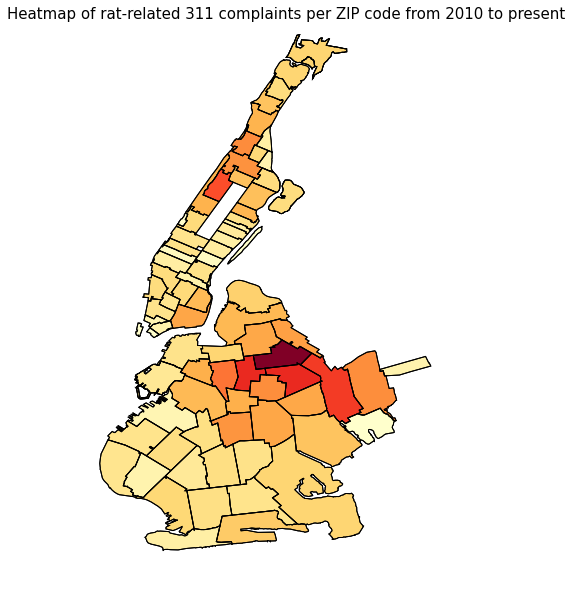

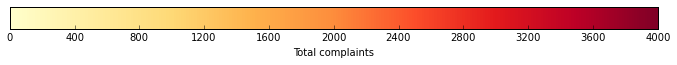

In [341]:
#Plotting heatmap of 311 complaints per zipcode
fig1 = pl.figure(figsize=(10, 10))
fig1 = nyc_map.plot(column='Total Complaints', alpha=1, colormap='YlOrRd')
fig1.axis('off')
pl.title("Heatmap of rat-related 311 complaints per ZIP code from 2010 to present", fontsize=15)

fig2 = pl.figure(figsize=(10, 2))
ax1 = fig2.add_axes([0.05, 0.80, 0.9, 0.15])
cmap = mpl.cm.YlOrRd
norm = mpl.colors.Normalize(vmin=0, vmax=4000)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=norm,orientation='horizontal')
cb1.set_label('Total complaints')

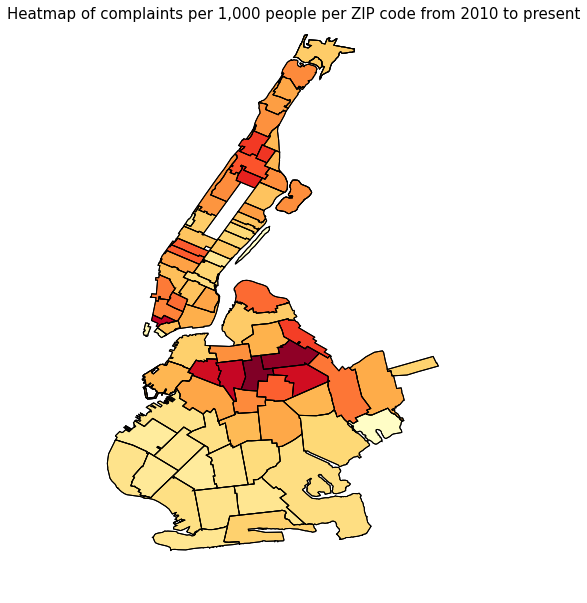

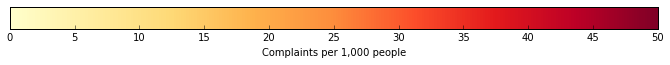

In [342]:
#Plotting heatmap of 311 complaints per zipcode
fig1 = pl.figure(figsize=(10, 10))
fig1 = nyc_map.plot(column='Complaints Per 1,000 People', alpha=1, colormap='YlOrRd')
fig1.axis('off')
pl.title("Heatmap of complaints per 1,000 people per ZIP code from 2010 to present", fontsize=15)

fig2 = pl.figure(figsize=(10, 2))
ax1 = fig2.add_axes([0.05, 0.80, 0.9, 0.15])
cmap = mpl.cm.YlOrRd
norm = mpl.colors.Normalize(vmin=0, vmax=50)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=norm,orientation='horizontal')
cb1.set_label('Complaints per 1,000 people')

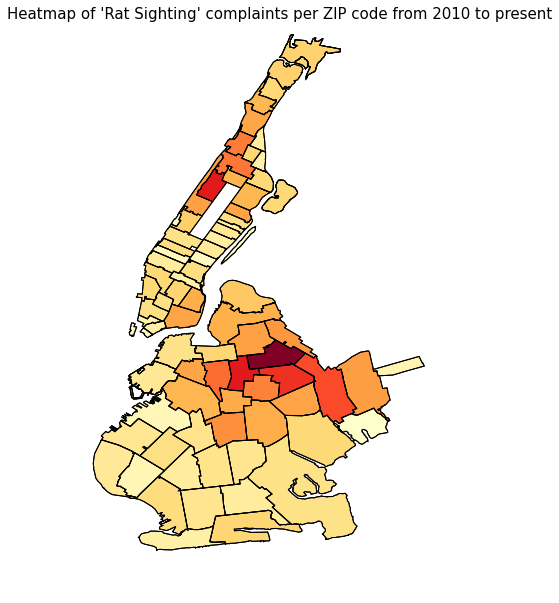

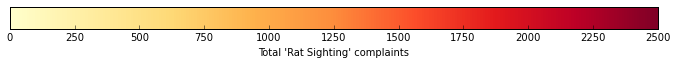

In [343]:
#Plotting heatmap of 311 complaints per zipcode
fig1 = pl.figure(figsize=(10, 10))
fig1 = nyc_map.plot(column='Rat Sighting', alpha=1, colormap='YlOrRd')
fig1.axis('off')
pl.title("Heatmap of 'Rat Sighting' complaints per ZIP code from 2010 to present", fontsize=15)

fig2 = pl.figure(figsize=(10, 2))
ax1 = fig2.add_axes([0.05, 0.80, 0.9, 0.15])
cmap = mpl.cm.YlOrRd
norm = mpl.colors.Normalize(vmin=0, vmax=2500)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=norm,orientation='horizontal')
cb1.set_label("Total 'Rat Sighting' complaints")

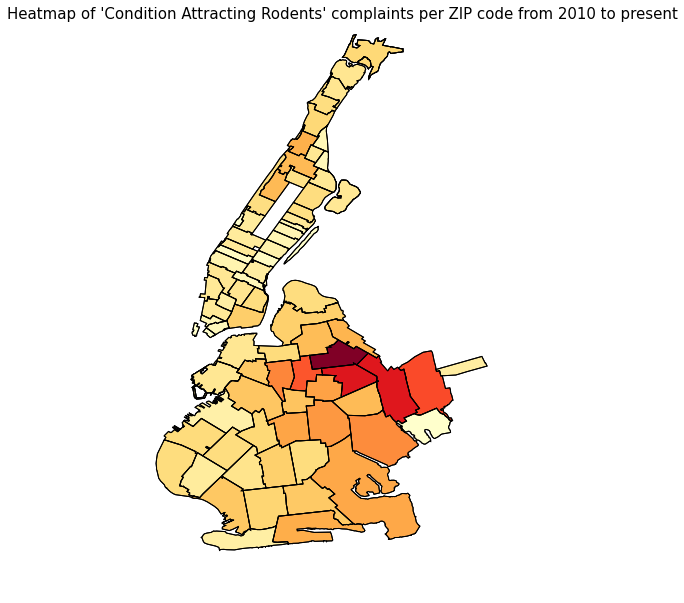

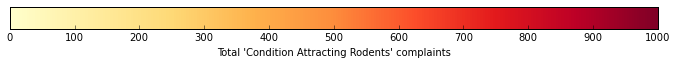

In [344]:
#Plotting heatmap of 311 complaints per zipcode
#Brooklyn/Queens inhabitants tend to be more vigilant about rats
fig1 = pl.figure(figsize=(10, 10))
fig1 = nyc_map.plot(column='Condition Attracting Rodents', alpha=1, colormap='YlOrRd')
fig1.axis('off')
pl.title("Heatmap of 'Condition Attracting Rodents' complaints per ZIP code from 2010 to present", fontsize=15)

fig2 = pl.figure(figsize=(10, 2))
ax1 = fig2.add_axes([0.05, 0.80, 0.9, 0.15])
cmap = mpl.cm.YlOrRd
norm = mpl.colors.Normalize(vmin=0, vmax=1000)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=norm,orientation='horizontal')
cb1.set_label("Total 'Condition Attracting Rodents' complaints")

In [345]:
#Estimating linear model
X1 = df['Median Household Income']
Y1 = df['Total Complaints']

model1 = sm.OLS(Y1, sm.add_constant(X1), mising='drop').fit()
print model1.summary()
print model1.params

                            OLS Regression Results                            
Dep. Variable:       Total Complaints   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     21.47
Date:                Sun, 13 Dec 2015   Prob (F-statistic):           1.36e-05
Time:                        17:53:56   Log-Likelihood:                -647.37
No. Observations:                  83   AIC:                             1299.
Df Residuals:                      81   BIC:                             1304.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
const                    1

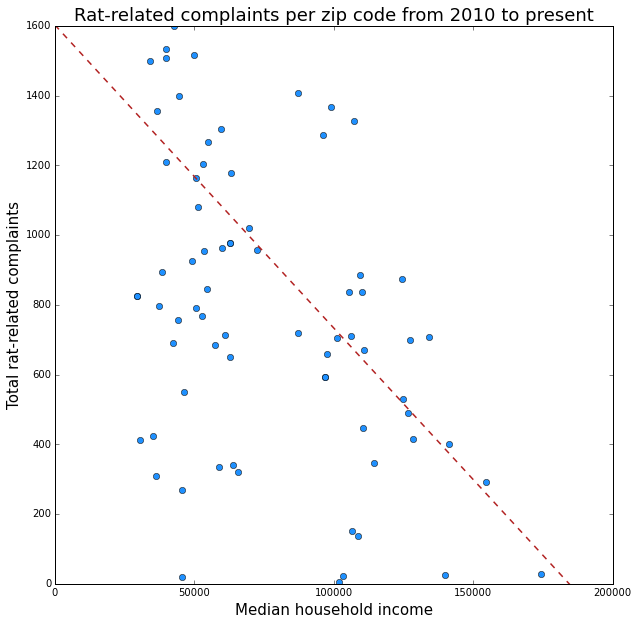

In [346]:
#Plotting linear model
#Problem: low-income neighborhoods tend to be more populous, which tends to increase the number of complaints
#So we're next doing the calculation with complaints per 1,000 people
pl.figure(figsize=(10, 10))
pl.plot(X1, Y1, 'o', color = 'dodgerblue')
xlim(0,200000)
ylim(0, 1600)
XLR1 = arange(0, 200000, 0.1)
YLR1 = model1.params[1]*XLR1+model1.params[0]
pl.plot(XLR1, YLR1, '--', linewidth = 1.50, color = 'firebrick')
pl.xlabel("Median household income", fontsize=15)
pl.ylabel("Total rat-related complaints", fontsize=15)
pl.title("Rat-related complaints per zip code from 2010 to present", fontsize=18)

In [347]:
#Estimating second degree linear model
model2 = smf.ols(formula = 'Y ~ X + I((X)) + I((X)**2)', 
        data={'X': df['Median Household Income'],'Y': df['Total Complaints']}).fit()
print model2.summary()

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     10.60
Date:                Sun, 13 Dec 2015   Prob (F-statistic):           8.22e-05
Time:                        17:54:05   Log-Likelihood:                -647.37
No. Observations:                  83   AIC:                             1301.
Df Residuals:                      80   BIC:                             1308.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    1588.1831    360.056      4.411      

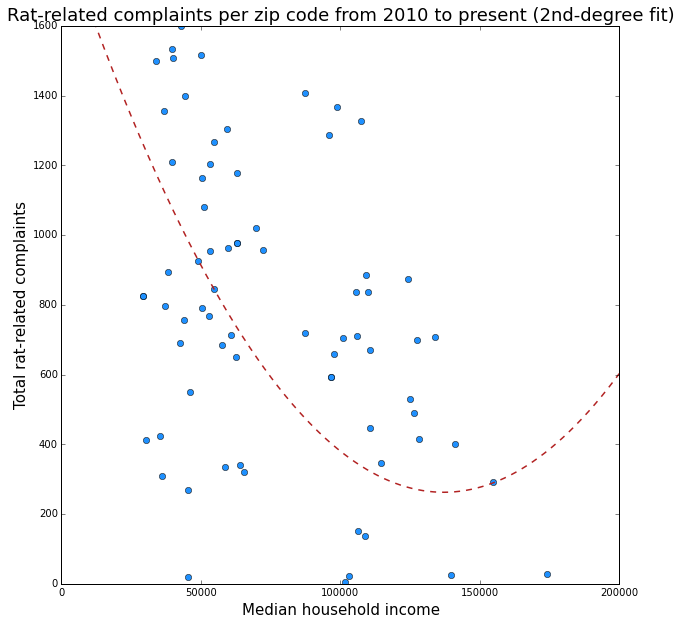

In [348]:
secdegree2 = np.polyfit(X, Y, 2)
fig2 = pl.figure(figsize=(10, 10))
pl.plot(X1, Y1, 'o', color = 'dodgerblue')
xlim(0,200000)
ylim(0, 1600)
XLR2 = arange(0, 200000, 0.1)
YLR2 = secdegree2[0]*XLR2**2+secdegree2[1]*XLR2+secdegree2[2]
pl.plot(XLR2, YLR2, '--', linewidth = 1.50, color = 'firebrick')
pl.xlabel("Median household income", fontsize=15)
pl.ylabel("Total rat-related complaints", fontsize=15)
pl.title("Rat-related complaints per zip code from 2010 to present (2nd-degree fit)", fontsize=18)

In [349]:
#Estimating linear model
#A problem of this approach is that higher populational density might drive rat complaints
X3 = df['Median Household Income']
Y3 = df['Complaints Per 1,000 People']

model3 = sm.OLS(Y3, sm.add_constant(X3), mising='drop').fit()
print model3.summary()
print model3.params

                                 OLS Regression Results                                
Dep. Variable:     Complaints Per 1,000 People   R-squared:                       0.026
Model:                                     OLS   Adj. R-squared:                  0.014
Method:                          Least Squares   F-statistic:                     2.159
Date:                         Sun, 13 Dec 2015   Prob (F-statistic):              0.146
Time:                                 17:54:14   Log-Likelihood:                -308.82
No. Observations:                           83   AIC:                             621.6
Df Residuals:                               81   BIC:                             626.5
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------

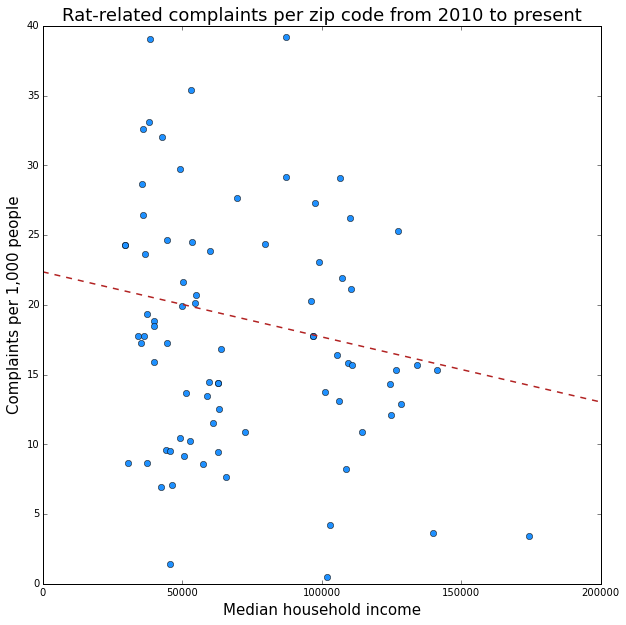

In [350]:
#Plotting linear model
pl.figure(figsize=(10, 10))
pl.plot(X3, Y3, 'o', color = 'dodgerblue')
xlim(0,200000)
ylim(0, 40)
XLR3 = arange(0, 200000, 0.1)
YLR3 = model3.params[1]*XLR3+model3.params[0]
pl.plot(XLR3, YLR3, '--', linewidth = 1.50, color = 'firebrick')
pl.xlabel("Median household income", fontsize=15)
pl.ylabel("Complaints per 1,000 people", fontsize=15)
pl.title("Rat-related complaints per zip code from 2010 to present", fontsize=18)

In [351]:
#Estimating second degree linear model
model4 = smf.ols(formula = 'Y ~ X + I((X)) + I((X)**2)', 
        data={'X': df['Median Household Income'],'Y': df['Complaints Per 1,000 People']}).fit()
print model4.summary()

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.084
Date:                Sun, 13 Dec 2015   Prob (F-statistic):              0.343
Time:                        17:54:33   Log-Likelihood:                -308.80
No. Observations:                  83   AIC:                             623.6
Df Residuals:                      80   BIC:                             630.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept      23.3860      6.093      3.838      

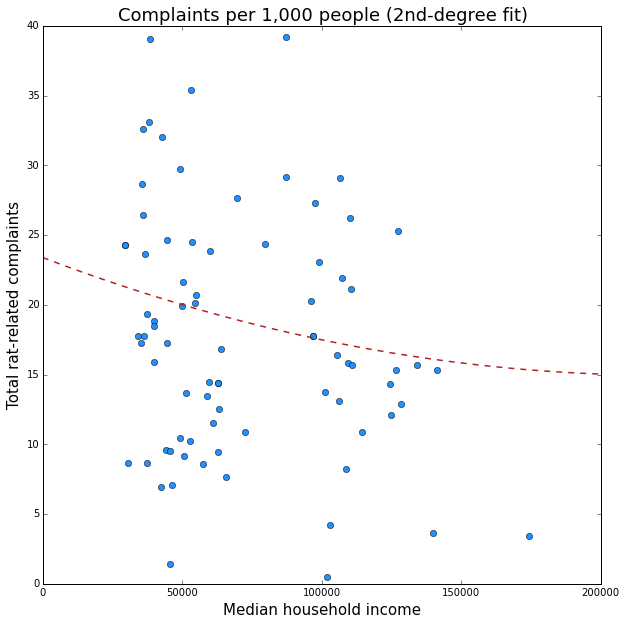

In [352]:
secdegree4 = np.polyfit(X3, Y3, 2)
fig4 = pl.figure(figsize=(10, 10))
pl.plot(X3, Y3, 'o', color = 'dodgerblue')
xlim(0,200000)
ylim(0, 40)
XLR4 = arange(0, 200000, 0.1)
YLR4 = secdegree4[0]*XLR4**2+secdegree4[1]*XLR4+secdegree4[2]
pl.plot(XLR4, YLR4, '--', linewidth = 1.50, color = 'firebrick')
pl.xlabel("Median household income", fontsize=15)
pl.ylabel("Total rat-related complaints", fontsize=15)
pl.title("Complaints per 1,000 people (2nd-degree fit)", fontsize=18)

In [361]:
#Top 15 ZIPs
top15 = df[['ZIP', 'Complaints Per 1,000 People', 'Median Household Income']]
top15['Income as % of NYC Avg'] = ["{:.2f}%".format(i) for i in top15['Median Household Income']/df['Median Household Income'].mean()*100] 
top15 = top15.drop('Median Household Income', 1)
top15 = top15.sort(['Complaints Per 1,000 People'], ascending=[False])
top15.index = [i+1 for i in range(len(top15))]
top15 = top15[top15.index <= 15]
top15

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,ZIP,"Complaints Per 1,000 People",Income as % of NYC Avg
1,11216,48.144193,61.87%
2,11221,46.492173,54.52%
3,10007,41.785919,213.30%
4,11238,40.842840,96.54%
5,11217,39.185084,120.35%
6,11233,39.058655,52.92%
7,10026,35.408640,73.37%
8,10030,33.112337,52.73%
9,10031,32.566710,49.36%
10,11237,32.046657,58.94%


In [368]:
#Bottom 10 ZIPs
#Complaints >15
bottom15 = df[['ZIP', 'Complaints Per 1,000 People', 'Median Household Income']]
bottom15['Income as % of NYC Avg'] = ["{:.2f}%".format(i) for i in bottom15['Median Household Income']/df['Median Household Income'].mean()*100] 
bottom15 = bottom15.drop('Median Household Income', 1)
bottom15 = bottom15.sort(['Complaints Per 1,000 People'], ascending=[True])
bottom15.index = [i+1 for i in range(len(bottom15))]
bottom15 = bottom15[bottom15.index <= 15]
bottom15

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ZIP,"Complaints Per 1,000 People",Income as % of NYC Avg
1,10044,0.514536,140.27%
2,11239,1.418652,62.79%
3,10280,3.438176,240.27%
4,10005,3.644008,192.76%
5,10069,4.231583,142.16%
6,11220,6.927850,58.57%
7,11204,7.051988,63.63%
8,11228,7.681631,90.40%
9,10017,8.205128,150.01%
10,11229,8.573071,79.25%


In [353]:
#Estimating linear model
X5 = df['YearBuilt']
Y5 = df['Complaints Per 1,000 People']

model5 = sm.OLS(Y5, sm.add_constant(X5), mising='drop').fit()
print model5.summary()
print model5.params

                                 OLS Regression Results                                
Dep. Variable:     Complaints Per 1,000 People   R-squared:                       0.204
Model:                                     OLS   Adj. R-squared:                  0.194
Method:                          Least Squares   F-statistic:                     20.77
Date:                         Sun, 13 Dec 2015   Prob (F-statistic):           1.81e-05
Time:                                 17:54:51   Log-Likelihood:                -300.44
No. Observations:                           83   AIC:                             604.9
Df Residuals:                               81   BIC:                             609.7
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------

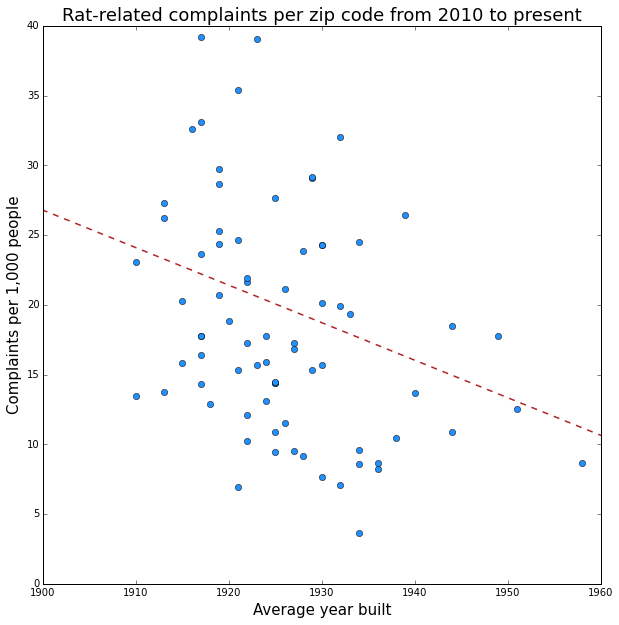

In [354]:
#Plotting linear model
pl.figure(figsize=(10, 10))
pl.plot(X5, Y5, 'o', color = 'dodgerblue')
xlim(1900,1960)
ylim(0, 40)
XLR5 = arange(0, 200000, 0.1)
YLR5 = model5.params[1]*XLR5+model5.params[0]
pl.plot(XLR5, YLR5, '--', linewidth = 1.50, color = 'firebrick')
pl.xlabel("Average year built", fontsize=15)
pl.ylabel("Complaints per 1,000 people", fontsize=15)
pl.title("Rat-related complaints per zip code from 2010 to present", fontsize=18)

In [357]:
#Estimating second degree linear model
model6 = smf.ols(formula = 'Y ~ X + I((X)) + I((X)**2)', 
        data={'X': df['YearBuilt'],'Y': df['Complaints Per 1,000 People']}).fit()
print model6.summary()

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     10.48
Date:                Sun, 13 Dec 2015   Prob (F-statistic):           9.07e-05
Time:                        17:58:40   Log-Likelihood:                -300.25
No. Observations:                  83   AIC:                             606.5
Df Residuals:                      80   BIC:                             613.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    5113.6643   7664.224      0.667      

In [360]:
model7 = smf.ols(formula = 'Y ~ X1 + X2', data={'X1': df['YearBuilt'],'X2': df['Median Household Income'], \
                                                     'Y': df['Complaints Per 1,000 People']}).fit()
print model7.summary()

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     11.81
Date:                Sun, 13 Dec 2015   Prob (F-statistic):           3.21e-05
Time:                        18:15:35   Log-Likelihood:                -299.17
No. Observations:                  83   AIC:                             604.3
Df Residuals:                      80   BIC:                             611.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    538.6055    112.875      4.772      0.0

In [433]:
#Estimating linear model
X8 = df['Income Growth']
Y8 = df['Complaints 2014-15 Per 1,000 People']

model8 = sm.OLS(Y8, sm.add_constant(X8), mising='drop').fit()
print model8.summary()
print model8.params

                                     OLS Regression Results                                    
Dep. Variable:     Complaints 2014-15 Per 1,000 People   R-squared:                       0.187
Model:                                             OLS   Adj. R-squared:                  0.177
Method:                                  Least Squares   F-statistic:                     18.21
Date:                                 Sun, 13 Dec 2015   Prob (F-statistic):           5.46e-05
Time:                                         21:46:01   Log-Likelihood:                -223.56
No. Observations:                                   81   AIC:                             451.1
Df Residuals:                                       79   BIC:                             455.9
Df Model:                                            1                                         
Covariance Type:                             nonrobust                                         
                    coef    std err     

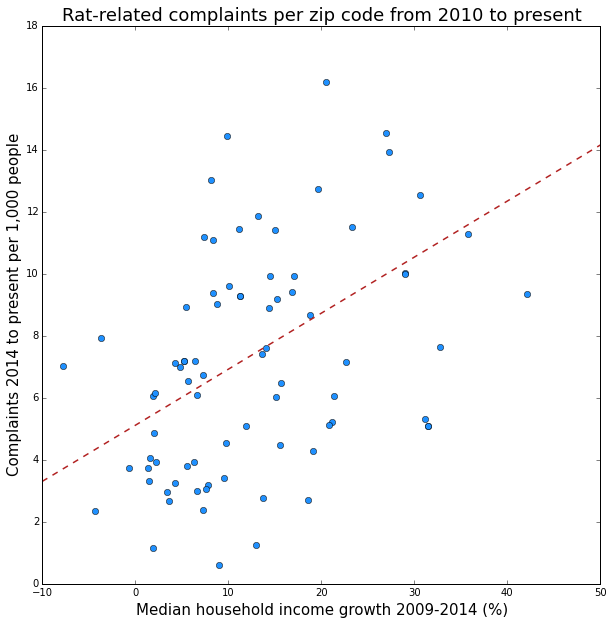

In [443]:
#Plotting linear model
#http://citylimits.org/2013/02/27/debate-over-size-of-brooklyns-rat-problem-what-to-do-about-it/
pl.figure(figsize=(10, 10))
pl.plot(X8, Y8, 'o', color = 'dodgerblue')
xlim(-10, 50)
ylim(0, 18)
XLR8 = arange(-10, 100, 0.1)
YLR8 = model8.params[1]*XLR8+model8.params[0]
pl.plot(XLR8, YLR8, '--', linewidth = 1.50, color = 'firebrick')
pl.xlabel("Median household income growth 2009-2014 (%)", fontsize=15)
pl.ylabel("Complaints 2014 to present per 1,000 people", fontsize=15)
pl.title("Rat-related complaints per zip code from 2010 to present", fontsize=18)

In [440]:
#Estimating second degree linear model
model6 = smf.ols(formula = 'Y ~ X + I((X)) + I((X)**2)', 
        data={'X': df['Income Growth'],'Y': df['Complaints 2014-15 Per 1,000 People']}).fit()
print model6.summary()

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     9.550
Date:                Sun, 13 Dec 2015   Prob (F-statistic):           0.000195
Time:                        21:50:22   Log-Likelihood:                -223.09
No. Observations:                  81   AIC:                             452.2
Df Residuals:                      78   BIC:                             459.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       4.6366      0.857      5.413      

In [563]:
#Creating time series with complaints
ts_311 = data_311
ts_311['Created Date'] =  pd.to_datetime(ts_311['Created Date'])
ts_311 = ts_311.set_index('Created Date')
ts_311.index.name = None 
ts_311 = ts_311.groupby(pd.TimeGrouper("M")).resample("M", how='count')
ts_311 = ts_311[['Unique Key']]
ts_311['Date'] = [ts_311.index[i][0] for i in range(len(ts_311))]
ts_311.index = range(len(ts_311))
ts_311 = ts_311.rename(columns = {'Unique Key':'Total Complaints'})
ts_311 = ts_311[ts_311.index < 71]
ts_311['Month'] = pd.DatetimeIndex(ts_311['Date']).month
ts_311['Year'] = pd.DatetimeIndex(ts_311['Date']).year
ts_311_10 = ts_311[ts_311['Year'] == 2010]
ts_311_11 = ts_311[ts_311['Year'] == 2011]
ts_311_12 = ts_311[ts_311['Year'] == 2012]
ts_311_13 = ts_311[ts_311['Year'] == 2013]
ts_311_14 = ts_311[ts_311['Year'] == 2014]
ts_311_15 = ts_311[ts_311['Year'] == 2015]
ts_311_10.head()

,Total Complaints,Date,Month,Year
0,1256,2010-01-31,1,2010
1,1014,2010-02-28,2,2010
2,1695,2010-03-31,3,2010
3,1857,2010-04-30,4,2010
4,2085,2010-05-31,5,2010


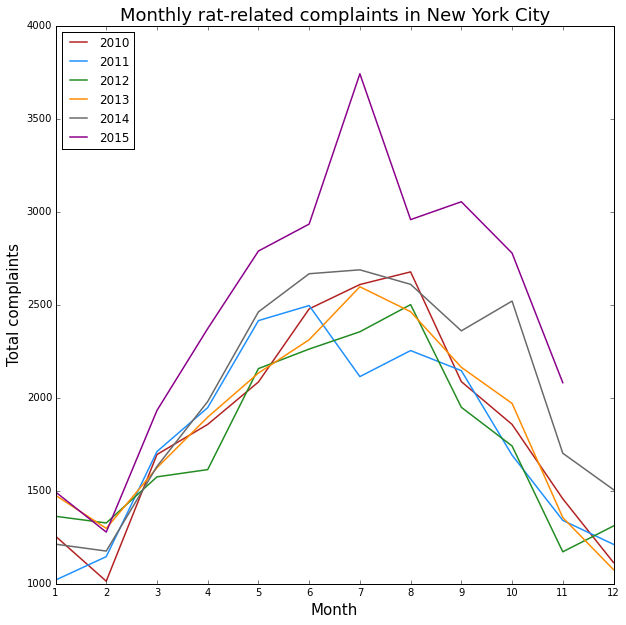

In [582]:
#https://www.washingtonpost.com/local/the-gripe-rats-in-dc-are-a-sign-of-summer/2013/08/07/32be9cf4-fe9f-11e2-bd97-676ec24f1f3f_story.html
pl.figure(figsize=(10, 10))
pl.plot(ts_311_10['Month'], ts_311_10['Total Complaints'], '-', linewidth = 1.50, color = 'firebrick', label = '2010')
pl.plot(ts_311_11['Month'], ts_311_11['Total Complaints'], '-', linewidth = 1.50, color = 'dodgerblue', label = '2011')
pl.plot(ts_311_12['Month'], ts_311_12['Total Complaints'], '-', linewidth = 1.50, color = 'forestgreen', label = '2012')
pl.plot(ts_311_13['Month'], ts_311_13['Total Complaints'], '-', linewidth = 1.50, color = 'darkorange', label = '2013')
pl.plot(ts_311_14['Month'], ts_311_14['Total Complaints'], '-', linewidth = 1.50, color = 'dimgrey', label = '2014')
pl.plot(ts_311_15['Month'], ts_311_15['Total Complaints'], '-', linewidth = 1.50, color = 'darkmagenta', label = '2015')
pl.xticks(range(1, 13, 1))
pl.legend(loc='upper left')
xlim(1, 12)
pl.xlabel("Month", fontsize=15)
pl.ylabel("Total complaints", fontsize=15)
pl.title("Monthly rat-related complaints in New York City", fontsize=18)